# Exploring PPO RL using multiple workers with Ray Rllib

In [1]:
import os
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy

import gymnasium as gym
import matplotlib.pyplot as plt
from pprint import pprint
from ray import air, tune
import numpy as np
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.registry import register_env

# sixg_radio_mgmt
from sixg_radio_mgmt import (
    CommunicationEnv,
    Association,
    UEs,
    Channel,
    Mobility,
    Traffic,
    Agent,
)
from typing import Optional, Tuple, Union

In [2]:
class SimpleAssociation(Association):
    def __init__(
        self,
        ues: UEs,
        max_number_ues: int,
        max_number_basestations: int,
        max_number_slices: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
        scenario_name: str = "",
    ) -> None:
        super().__init__(
            ues,
            max_number_ues,
            max_number_basestations,
            max_number_slices,
            rng,
            root_path,
            scenario_name,
        )
        self.basestation_ue_assoc = np.ones((1, max_number_ues), dtype=int)
        self.basestation_slice_assoc = np.ones((1, max_number_slices), dtype=int)
        self.slice_ue_assoc = np.ones((1, max_number_ues), dtype=int)

    def step(
        self,
        basestation_ue_assoc: np.ndarray,
        basestation_slice_assoc: np.ndarray,
        slice_ue_assoc: np.ndarray,
        slice_req: Optional[dict],
        step_number: int,
        episode_number: int,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Optional[dict]]:
        return (
            basestation_ue_assoc,
            basestation_slice_assoc,
            slice_ue_assoc,
            slice_req,
        )

In [3]:
class MimicQuadriga(Channel):
    def __init__(
        self,
        max_number_ues: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
        scenario_name: str = "",
    ) -> None:
        super().__init__(
            max_number_ues,
            max_number_basestations,
            num_available_rbs,
            rng,
            root_path,
            scenario_name,
        )
        self.current_episode_number = -1
        self.ues_mean_se = np.array([])
        self.default_std = 1.5

    def step(
        self,
        step_number: int,
        episode_number: int,
        mobilities: np.ndarray,
        sched_decision: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        if episode_number != self.current_episode_number:
            self.current_episode_number = episode_number
            self.ues_mean_se = np.abs(
                self.rng.normal(10, 7.5, size=(self.max_number_ues,))
            )

        spectral_efficiencies = np.array(
            [
                np.ones((self.max_number_ues, self.num_available_rbs[i]))
                for i in np.arange(self.max_number_basestations)
            ]
        )
        for ue_idx, ue_mean in enumerate(self.ues_mean_se):
            spectral_efficiencies[0, ue_idx, :] = np.abs(
                self.rng.normal(
                    ue_mean,
                    self.default_std,
                    size=(self.num_available_rbs[0],),
                )
            )

        return spectral_efficiencies

In [4]:
class SimpleMobility(Mobility):
    def __init__(
        self,
        max_number_ues: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
    ) -> None:
        super().__init__(max_number_ues, rng, root_path)

    def step(self, step_number: int, episode_number: int) -> np.ndarray:
        return np.ones((self.max_number_ues, 2))

In [5]:
class DefaultTraffic(Traffic):
    def __init__(
        self,
        max_number_ues: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
    ) -> None:
        super().__init__(max_number_ues, rng, root_path)
        self.traffics_pattern = {
            "embb": {
                "num_ues": 5,
                "ue_throughput": 100,
            },
            "urllc": {
                "num_ues": 5,
                "ue_throughput": 10,
            },
        }

    def step(
        self,
        slice_ue_assoc: np.ndarray,
        slice_req: dict,
        step_number: int,
        episode_number: int,
    ) -> np.ndarray:
        traffic_per_ue = np.zeros(self.max_number_ues)

        # eMBB
        traffic_per_ue[0 : self.traffics_pattern["embb"]["num_ues"]] = (
            self.rng.poisson(
                self.traffics_pattern["embb"]["ue_throughput"],
                self.traffics_pattern["embb"]["num_ues"],
            )
            * 1e6
        )  # Mbps
        # URLLC
        traffic_per_ue[
            self.traffics_pattern["embb"]["num_ues"] : self.traffics_pattern["embb"][
                "num_ues"
            ]
            + self.traffics_pattern["urllc"]["num_ues"]
        ] = (
            self.rng.poisson(
                self.traffics_pattern["urllc"]["ue_throughput"],
                self.traffics_pattern["urllc"]["num_ues"],
            )
            * 1e6
        )  # Mbps

        return traffic_per_ue

In [6]:
class RoundRobin(Agent):
    def __init__(
        self,
        env: CommunicationEnv,
        max_number_ues: int,
        max_number_slices: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
    ) -> None:
        super().__init__(
            env,
            max_number_ues,
            max_number_slices,
            max_number_basestations,
            num_available_rbs,
        )

    def step(self, obs_space: Union[np.ndarray, dict]) -> np.ndarray:
        allocation_rbs = [
            np.zeros((self.max_number_ues, self.num_available_rbs[basestation]))
            for basestation in np.arange(self.max_number_basestations)
        ]
        for basestation in np.arange(self.max_number_basestations):
            ue_idx = 0
            rb_idx = 0
            while rb_idx < self.num_available_rbs[basestation]:
                if obs_space[basestation][ue_idx] == 1:
                    allocation_rbs[basestation][ue_idx][rb_idx] += 1
                    rb_idx += 1
                ue_idx += 1 if ue_idx + 1 != self.max_number_ues else -ue_idx

        return np.array(allocation_rbs)

    def obs_space_format(self, obs_space: dict) -> np.ndarray:
        return np.array(obs_space["basestation_ue_assoc"])

    def calculate_reward(self, obs_space: dict) -> float:
        return 0

    def action_format(self, action: Union[np.ndarray, dict]) -> np.ndarray:
        assert isinstance(action, np.ndarray), "Action must be a numpy array"
        return action

In [7]:
seed = 10
number_ues = 10
number_basestations = 1
number_slices = 1
rbs_available = np.array([100])
comm_env = CommunicationEnv(
    ChannelClass=MimicQuadriga,
    TrafficClass=DefaultTraffic,
    MobilityClass=SimpleMobility,
    AssociationClass=SimpleAssociation,
    config_file="rrs_simple",
    simu_name="rrs_simple",
    agent_name="round_robin",
    seed=seed,
)
round_robin = RoundRobin(
    comm_env, number_ues, number_slices, number_basestations, rbs_available
)
comm_env.set_agent_functions(
    obs_space_format=round_robin.obs_space_format,
    action_format=round_robin.action_format,
    calculate_reward=round_robin.calculate_reward,
)

steps_per_episode = 1000
training_episodes = 80
training_epochs = 1
testing_episodes = 20

# Test
comm_env.max_number_episodes = training_episodes + testing_episodes
obs = comm_env.reset(seed=seed, options={"initial_episode": training_episodes})[0]
for step_number in tqdm(np.arange(testing_episodes * steps_per_episode)):
    sched_decision = round_robin.step(obs)
    obs, _, end_ep, _, _ = comm_env.step(sched_decision)
    if end_ep:
        comm_env.reset()

100%|██████████| 20000/20000 [00:21<00:00, 922.69it/s] 


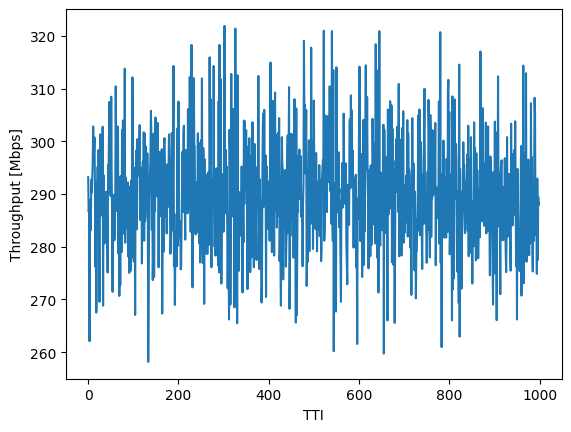

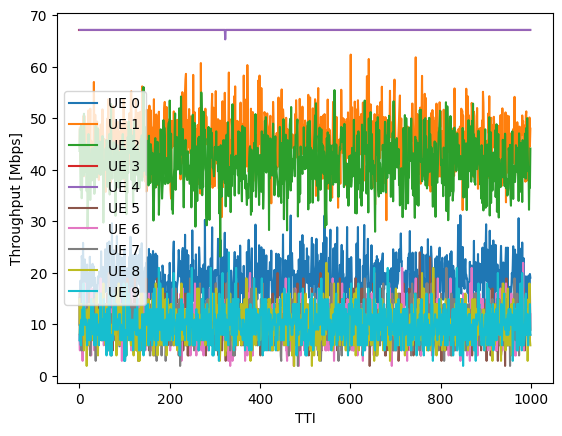

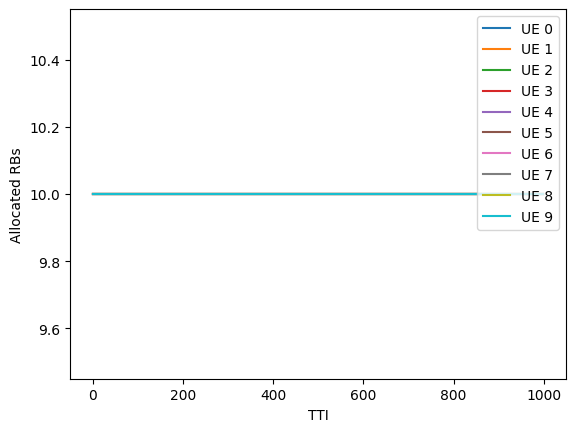

Total throughput achieved: 289972.092928


In [8]:
hist_ep_80 = np.load("hist/rrs_simple/round_robin/ep_80.npz")
pkt_size = 65536  # Default packet size in bits
effective_throughput = hist_ep_80["pkt_effective_thr"] * pkt_size / 1e6
pkt_incoming = hist_ep_80["pkt_incoming"] * pkt_size / 1e6
total_throughput = np.sum(effective_throughput, axis=1)
rbs_per_ue = np.squeeze(hist_ep_80["sched_decision"]).sum(axis=2)

# Total achieved throughput
plt.figure()
plt.plot(total_throughput, label="Total throughput")
plt.xlabel("TTI")
plt.ylabel("Throughput [Mbps]")
plt.show()

# Achieved throughput per UE
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(effective_throughput[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Throughput [Mbps]")
plt.legend()
plt.show()

# RBs per UE
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(rbs_per_ue[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Allocated RBs")
plt.legend()
plt.show()
print(f"Total throughput achieved: {np.sum(total_throughput)}")

In [ ]:
class RLSimple(Agent):
    def __init__(
        self,
        env: CommunicationEnv,
        max_number_ues: int,
        max_number_slices: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        hyperparameters: dict = {},
        seed: int = np.random.randint(1000),
    ) -> None:
        super().__init__(
            env,
            max_number_ues,
            max_number_slices,
            max_number_basestations,
            num_available_rbs,
            seed,
        )
        self.agent_name = "ray_ppo"
        self.current_obs = None

    def step(self, obs_space: Union[np.ndarray, dict]) -> np.ndarray:
        return np.array([])

    def obs_space_format(self, obs_space: dict) -> Union[np.ndarray, dict]:
        self.current_obs = obs_space
        formatted_obs_space = np.array([])
        hist_labels = [
            "buffer_occupancies",
            # "spectral_efficiencies",
        ]
        for hist_label in hist_labels:
            if hist_label == "spectral_efficiencies":
                formatted_obs_space = np.append(
                    formatted_obs_space,
                    np.squeeze(np.sum(obs_space[hist_label], axis=2)),
                    axis=0,
                )
            else:
                formatted_obs_space = np.append(
                    formatted_obs_space, obs_space[hist_label], axis=0
                )

        return formatted_obs_space

    def calculate_reward(self, obs_space: dict) -> Union[float, dict]:
        reward = np.sum(obs_space["pkt_effective_thr"], dtype=float)
        return reward

    def action_format(
        self,
        action: Union[np.ndarray, dict],
    ) -> np.ndarray:
        curr_action = deepcopy(action)
        assert isinstance(curr_action, np.ndarray), "Action must be a numpy array"
        assert isinstance(
            self.current_obs, dict
        ), "Observation space must be a dictionary"
        sched_decision = np.array(
            [
                np.zeros((self.max_number_ues, self.num_available_rbs[basestation]))
                for basestation in np.arange(self.max_number_basestations)
            ]
        )
        active_ues = self.current_obs["slice_ue_assoc"][0, :].nonzero()[0]
        curr_action[np.where(self.current_obs["slice_ue_assoc"][0, :] == 0)[0]] = -1
        if np.sum(curr_action + 1) == 0:
            curr_action = -1 * np.ones_like(curr_action)
            curr_action[active_ues] = 1
        rbs_per_ue = np.floor(
            self.num_available_rbs[0] * (curr_action + 1) / np.sum(curr_action + 1)
        )
        assert not np.isnan(rbs_per_ue).any(), "NaN values in action"
        while np.sum(rbs_per_ue) != self.num_available_rbs[0]:
            rbs_per_ue[0] += 1

        sched_decision = self.distribute_rbs_ues(
            rbs_per_ue,
            sched_decision,
            active_ues,
            self.num_available_rbs,
            0,
        )

        assert (
            np.sum(sched_decision) == self.num_available_rbs[0]
        ), "Allocated RBs are different from available RBs"

        return sched_decision

    def get_action_space(
        self,
    ) -> gym.spaces.Box:
        return gym.spaces.Box(
            low=-1, high=1, shape=(self.max_number_ues,), dtype=np.float64
        )

    def get_obs_space(
        self,
    ) -> gym.spaces.Box:
        return gym.spaces.Box(
            low=0,
            high=np.inf,
            shape=(self.max_number_ues,),
            dtype=np.float64,
        )

    def distribute_rbs_ues(
        self,
        rbs_per_ue: np.ndarray,
        allocation_rbs: np.ndarray,
        slice_ues: np.ndarray,
        rbs_per_slice: np.ndarray,
        slice_idx: int,
    ) -> np.ndarray:
        rb_idx = np.sum(rbs_per_slice[:slice_idx], dtype=int)
        for idx, ue_idx in enumerate(slice_ues):
            allocation_rbs[0, ue_idx, rb_idx : rb_idx + rbs_per_ue[idx].astype(int)] = 1
            rb_idx += rbs_per_ue[idx].astype(int)

        return allocation_rbs

In [ ]:
def env_creator(env_config, training=True):
    comm_env = CommunicationEnv(
        ChannelClass=MimicQuadriga,
        TrafficClass=DefaultTraffic,
        MobilityClass=SimpleMobility,
        AssociationClass=SimpleAssociation,
        config_file="rrs_simple",
        simu_name="rrs_simple",
        agent_name="ray_ppo",
    )
    rl_api = RLSimple(
        comm_env,
        number_ues,
        number_slices,
        number_basestations,
        rbs_available,
    )
    comm_env.set_agent_functions(
        obs_space_format=rl_api.obs_space_format,
        action_format=rl_api.action_format,
        calculate_reward=rl_api.calculate_reward,
        obs_space=rl_api.get_obs_space(),
        action_space=rl_api.get_action_space(),
    )
    comm_env.max_number_episodes = 80 if training else 100

    return comm_env


register_env("comm_env", lambda config: env_creator(config))

In [11]:
config = (
    PPOConfig()
    .environment("comm_env")
    .env_runners(num_env_runners=1)
    .learners(num_learners=1)
)
stop = {
    "timesteps_total": 1000 * training_episodes * training_epochs,
}
checkpoint_frequency = 0
store_results_path = str(Path("./ray_results/").resolve()) + "/nb_3/"
agent_name = "ray_ppo"

tuner = tune.Tuner(
    "PPO",
    param_space=config.to_dict(),
    run_config=air.RunConfig(
        storage_path=store_results_path,
        name=agent_name,
        stop=stop,
        verbose=2,
        checkpoint_config=air.CheckpointConfig(
            checkpoint_frequency=checkpoint_frequency,
            checkpoint_at_end=True,
        ),
    ),
)
results = tuner.fit()
print(results)

2024-11-23 20:57:57,556	INFO worker.py:1783 -- Started a local Ray instance.
2024-11-23 20:57:59,227	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-11-23 20:57:59,231	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
/home/cleversonahum/.local/share/virtualenvs/ray_minicourse-cvA_mRW8/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/cleversonahum/.local/share/virtualenvs/ray_minicourse-cvA_mRW8/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to

(PPO pid=132767) Install gputil for GPU system monitoring.
(PPO pid=132767) 2024-11-23 20:58:17,253	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


Trial name,agent_timesteps_total,counters,custom_metrics,episode_media,info,num_agent_steps_sampled,num_agent_steps_sampled_lifetime,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_lifetime,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_healthy_workers,num_in_flight_async_sample_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,timers
PPO_comm_env_c4561_00000,80000,"{'num_env_steps_sampled': 80000, 'num_env_steps_trained': 80000, 'num_agent_steps_sampled': 80000, 'num_agent_steps_trained': 80000}",{},{},"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float32(3.0670009), 'cur_kl_coeff': np.float64(0.4500000000000001), 'cur_lr': np.float64(5.0000000000000016e-05), 'total_loss': np.float64(9.959786750424293), 'policy_loss': np.float64(-0.04880388107511305), 'vf_loss': np.float64(10.0), 'vf_explained_var': np.float64(-7.690921906502016e-09), 'kl': np.float64(0.01909030143690199), 'entropy': np.float64(14.368664463617469), 'entropy_coeff': np.float64(0.0)}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': np.float64(128.0), 'num_grad_updates_lifetime': np.float64(18135.5), 'diff_num_grad_updates_vs_sampler_policy': np.float64(464.5)}}, 'num_env_steps_sampled': 80000, 'num_env_steps_trained': 80000, 'num_agent_steps_sampled': 80000, 'num_agent_steps_trained': 80000}",80000,80000,80000,80000,80000,4000,300.146,80000,4000,300.146,1,0,0,4000,"{'cpu_util_percent': np.float64(14.236842105263158), 'ram_util_percent': np.float64(85.5421052631579)}","{'training_iteration_time_ms': 13351.022, 'restore_workers_time_ms': 0.028, 'training_step_time_ms': 13350.939, 'sample_time_ms': 8200.43, 'load_time_ms': 0.451, 'load_throughput': 8868387.779, 'learn_time_ms': 5145.146, 'learn_throughput': 777.432, 'synch_weights_time_ms': 3.758}"


(PPO pid=132767) 2024-11-23 20:58:26,323	WARNING ppo.py:667 -- The mean reward returned from the environment is 3974.6279296875 but the vf_clip_param is set to 10.0. Consider increasing it for policy: default_policy to improve value function convergence.
2024-11-23 21:02:40,118	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/cleversonahum/Documents/ray_minicourse/lesson_1/ray_results/nb_3/ray_ppo' in 0.0104s.
2024-11-23 21:02:40,174	INFO tune.py:1041 -- Total run time: 280.94 seconds (280.78 seconds for the tuning loop).


ResultGrid<[
  Result(
    metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float32(3.0670009), 'cur_kl_coeff': np.float64(0.4500000000000001), 'cur_lr': np.float64(5.0000000000000016e-05), 'total_loss': np.float64(9.959786750424293), 'policy_loss': np.float64(-0.04880388107511305), 'vf_loss': np.float64(10.0), 'vf_explained_var': np.float64(-7.690921906502016e-09), 'kl': np.float64(0.01909030143690199), 'entropy': np.float64(14.368664463617469), 'entropy_coeff': np.float64(0.0)}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': np.float64(128.0), 'num_grad_updates_lifetime': np.float64(18135.5), 'diff_num_grad_updates_vs_sampler_policy': np.float64(464.5)}}, 'num_env_steps_sampled': 80000, 'num_env_steps_trained': 80000, 'num_agent_steps_sampled': 80000, 'num_agent_steps_trained': 80000}, 'env_runners': {'episode_reward_max': np.float64(4979548.0), 'episode_

In [12]:
analysis = tune.ExperimentAnalysis(store_results_path + agent_name)
assert analysis.trials is not None, "Analysis trial is None"
checkpoint = analysis.get_last_checkpoint(analysis.trials[0])
tuner_agent = Algorithm.from_checkpoint(checkpoint)

(PPO pid=132767) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/cleversonahum/Documents/ray_minicourse/lesson_1/ray_results/nb_3/ray_ppo/PPO_comm_env_c4561_00000_0_2024-11-23_20-57-59/checkpoint_000000)


2024-11-23 21:02:40,229	WARNING deprecation.py:50 -- DeprecationWarning: `_enable_new_api_stack` has been deprecated. Use `AlgorithmConfig._enable_new_api_stack` instead. This will raise an error in the future!
/home/cleversonahum/.local/share/virtualenvs/ray_minicourse-cvA_mRW8/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:557: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/cleversonahum/.local/share/virtualenvs/ray_minicourse-cvA_mRW8/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor

In [13]:
comm_env = env_creator({})
obs, _ = comm_env.reset(
    seed=seed, options={"initial_episode": training_episodes}
)  # Initial observation
for episode in tqdm(range(testing_episodes * 1000)):
    action = tuner_agent.compute_single_action(  # Here we compute the action using the trained agent
        obs,
        explore=False,
    )
    assert isinstance(action, np.ndarray), "Action must be a numpy array"
    obs, reward, terminated, truncated, info = comm_env.step(
        action
    )  # Applying the action in the environment
    if terminated:
        comm_env.reset()

100%|██████████| 20000/20000 [00:37<00:00, 534.27it/s]


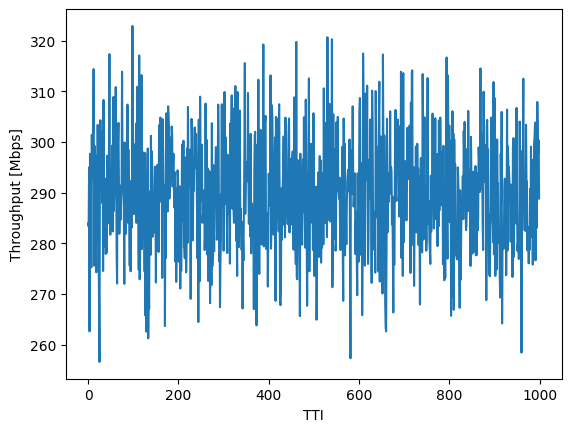

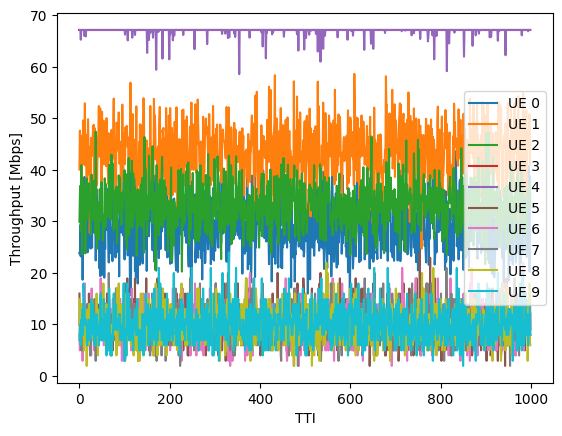

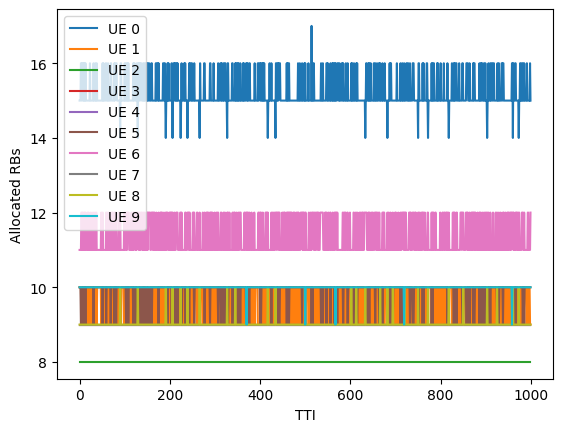

Total throughput achieved: 289661.124608


In [14]:
hist_ep_80 = np.load("hist/rrs_simple/ray_ppo/ep_80.npz")
pkt_size = 65536  # Default packet size in bits
effective_throughput = hist_ep_80["pkt_effective_thr"] * pkt_size / 1e6
pkt_incoming = hist_ep_80["pkt_incoming"] * pkt_size / 1e6
total_throughput = np.sum(effective_throughput, axis=1)
rbs_per_ue = np.squeeze(hist_ep_80["sched_decision"]).sum(axis=2)

# Total achieved throughput
plt.figure()
plt.plot(total_throughput, label="Total throughput")
plt.xlabel("TTI")
plt.ylabel("Throughput [Mbps]")
plt.show()

# Achieved throughput per UE
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(effective_throughput[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Throughput [Mbps]")
plt.legend()
plt.show()

# RBs per UE
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(rbs_per_ue[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Allocated RBs")
plt.legend()
plt.show()
print(f"Total throughput achieved: {np.sum(total_throughput)}")